Branching GP Regression on hematopoietic data
--

*Alexis Boukouvalas, 2017*

**Note:** this notebook is automatically generated by [Jupytext](https://jupytext.readthedocs.io/en/latest/index.html), see the REAMDME for instructions on working with it.

test change

Branching GP regression with Gaussian noise on the hematopoiesis data described in the paper "BGP: Gaussian processes for identifying branching dynamics in single cell data".

This notebook shows how to build a BGP model and plot the posterior model fit and posterior branching times.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Read the hematopoiesis data. This has been simplified to a small subset of 23 genes found to be branching.
We have also performed Monocle2 (version 2.1) - DDRTree on this data. The results loaded include the Monocle estimated pseudotime, branching assignment (state) and the DDRTree latent dimensions.

In [2]:
Y = pd.read_csv('singlecelldata/hematoData.csv', index_col=[0])
monocle = pd.read_csv('singlecelldata/hematoMonocle.csv', index_col=[0])

In [3]:
Y.head()

,CAR2,APOE,MPO,PRTN3,CTSG,CEBPA,FOXP1,RUNX1,CEBPE,GFI1,...,MEF2C,MEIS1,GATA2,NFE2,TAL1,GATA1,KLF1,FLT3,SATB1,ELANE
W29956,0.0,14.272981,7.136490,2.378830,4.757660,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,2.378830,0.000000,3.568245,0.0,0.000000,0.0,0.000000
W30018,0.0,0.000000,14.331045,18.239511,14.331045,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,2.605644,0.000000,0.000000,0.0,1.302822,0.0,0.000000
W30161,0.0,8.191847,0.000000,4.095923,4.095923,0.0,4.095923,0.000000,0.0,0.000000,...,4.095923,0.0,4.095923,12.287769,4.095923,0.000000,0.0,0.000000,0.0,0.000000
W30258,0.0,8.889219,11.428996,11.428996,0.000000,0.0,0.000000,1.269889,0.0,0.000000,...,0.000000,0.0,1.269889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
W30296,0.0,0.000000,64.317993,27.564854,15.313807,0.0,0.000000,0.000000,0.0,1.020921,...,0.000000,0.0,0.000000,1.020921,0.000000,0.000000,0.0,0.000000,0.0,7.146443


In [4]:
monocle.head()

,State,StretchedPseudotime,DDRTreeDim1,DDRTreeDim2
0,3.0,0.312208,-0.728425,-4.253484
1,2.0,0.256831,-3.131191,-2.867801
2,3.0,0.435655,3.106984,-4.869838
3,3.0,0.413354,0.881536,-5.958776
4,2.0,0.274771,-3.366619,-2.444610


In [5]:
gene_expressions_no_index = Y.reset_index(drop=True)
all_data = gene_expressions_no_index.merge(monocle, left_index=True, right_index=True)

all_data.head()

,CAR2,APOE,MPO,PRTN3,CTSG,CEBPA,FOXP1,RUNX1,CEBPE,GFI1,...,TAL1,GATA1,KLF1,FLT3,SATB1,ELANE,State,StretchedPseudotime,DDRTreeDim1,DDRTreeDim2
0,0.0,14.272981,7.136490,2.378830,4.757660,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,3.568245,0.0,0.000000,0.0,0.000000,3.0,0.312208,-0.728425,-4.253484
1,0.0,0.000000,14.331045,18.239511,14.331045,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,1.302822,0.0,0.000000,2.0,0.256831,-3.131191,-2.867801
2,0.0,8.191847,0.000000,4.095923,4.095923,0.0,4.095923,0.000000,0.0,0.000000,...,4.095923,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.435655,3.106984,-4.869838
3,0.0,8.889219,11.428996,11.428996,0.000000,0.0,0.000000,1.269889,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.413354,0.881536,-5.958776
4,0.0,0.000000,64.317993,27.564854,15.313807,0.0,0.000000,0.000000,0.0,1.020921,...,0.000000,0.000000,0.0,0.000000,0.0,7.146443,2.0,0.274771,-3.366619,-2.444610


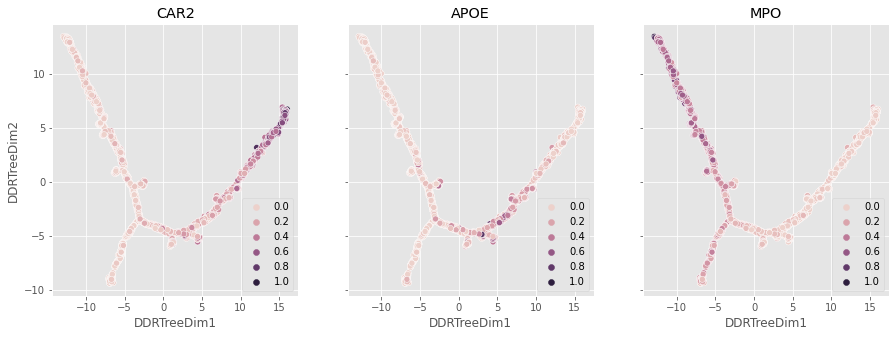

In [6]:
# Plot Monocle DDRTree space
import seaborn as sns
from typing import Sequence


def plot_genes(data: pd.DataFrame, genes: Sequence[str]) -> None:    
    n = len(genes)
    figure, axes = plt.subplots(1, n, figsize=(n*5, 5), sharex=True, sharey=True)
    
    for i, gene in enumerate(genes):
        y = data[gene].values
        yt = np.log(1+y/y.max())
        hue = yt/yt.max()
        sns.scatterplot(data=data, x="DDRTreeDim1", y="DDRTreeDim2", hue=hue, ax=axes[i])        
        
        axes[i].set_title(gene)

        
plot_genes(data=all_data, genes=Y.columns[0:3])

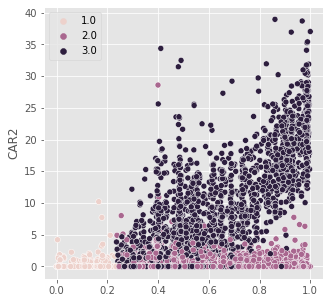

In [7]:
import matplotlib

OneDArray = np.ndarray  # Just a little helper alias to signal intended use


def plot_gene_on_axes(
        states: OneDArray, 
        pseudotime: OneDArray, 
        gene_values: OneDArray,
        axes: matplotlib.axes.Axes,
) -> matplotlib.axes.Axes:
    sns.scatterplot(
        x=pseudotime, 
        y=gene_values,
        hue=states,
        ax=axes,
    ) 
    return axes


# Quick test
def plot_gene(
        data: pd.DataFrame,
        gene: str,
) -> None:
    figure, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_gene_on_axes(
        states=data["State"].values,
        pseudotime=data["StretchedPseudotime"].values,
        gene_values=data[gene],
        axes=axes,
    )


plot_gene(data=all_data, gene="CAR2")

### Fit BGP model
Notice the cell assignment uncertainty is higher for cells close to the branching point.


In [8]:
import BranchedGP
import time
from typing import Any, Dict, Tuple

Results = Dict[str, Any]  # See BranchedGP.FitBranchingModel.FitModel for the results dict


def fit_and_plot_bgp(
        gene: str, 
        data: pd.DataFrame,
) -> Tuple[Results, matplotlib.figure.Figure, matplotlib.axes.Axes, float]:
    start_time = time.time()
    candidate_branching_pts = list(np.linspace(0.05, 0.95, 5)) + [1.1]

    # collect model training data; ensure gene expression data is 0-centered
    training_data_mean = data[gene].values.mean()
    y = data[gene].values - training_data_mean
    t = data["StretchedPseudotime"].values
    
    global_branching = data["State"].values.astype(int)
    d = BranchedGP.FitBranchingModel.FitModel(candidate_branching_pts, t, y.reshape(-1, 1), global_branching)
    
    print(f"BGP inference completed in {time.time() - start_time:.1f} seconds")
    
    fig, ax = BranchedGP.VBHelperFunctions.PlotBGPFit(y, t, candidate_branching_pts, d, figsize=(10,10))
     
    return d, fig, ax, training_data_mean

In [ ]:
# subsampling for speed
NUM_SAMPLES = 10


for gene in ["MPO", "CTSG"]:
    results_dict, figure, axes, training_data_mean = fit_and_plot_bgp(
        gene=gene, 
        data=all_data.sample(NUM_SAMPLES)
    )
    
    # Add the data
    plot_gene_on_axes(
        states=all_data["State"].values,
        pseudotime=all_data["StretchedPseudotime"].values,
        gene_values=all_data[gene] - training_data_mean,  # We fit on normalised data
        axes=axes[0],
    )
    # Calculate Bayes factor of branching vs non-branching
    bf = BranchedGP.VBHelperFunctions.CalculateBranchingEvidence(results_dict)["logBayesFactor"]

    figure.suptitle(f"{gene} log Bayes factor of branching: {bf:.1f}")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use the `axis` argument instead


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 263.061232
  Number of iterations: 46
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 263.061232
  Number of iterations: 46
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 296.343237
  Number of iterations: 29
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 296.343237
  Number of iterations: 29
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 435.469848
  Number of iterations: 45
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 435.469848
  Number of iterations: 45
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 396.121733
  Number of iterations: 44
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 396.121733
  Number of iterations: 44
  Number of functions evaluations: 50
